In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [41]:
PROC = Path("../data/processed")
FIGS = Path("figures")
FIGS.mkdir(exist_ok=True)

movies = pd.read_csv(PROC / "movies_clean.csv")
ratings = pd.read_csv(PROC / "ratings_clean.csv")


In [42]:
n_users  = ratings["userId"].nunique()
n_movies = ratings["movieId"].nunique()
print(f"Usuários únicos: {n_users:,}")
print(f"Filmes (após filtro): {n_movies:,}")
print(f"Avaliações totais: {len(ratings):,}")


Usuários únicos: 162,540
Filmes (após filtro): 10,326
Avaliações totais: 24,443,380


In [43]:
total_possible = n_users * n_movies
sparsity = 1 - len(ratings) / total_possible
print(f"Sparsidade ≈ {sparsity:.4%}")


Sparsidade ≈ 98.5436%


In [44]:
ratings_per_movie = ratings.groupby("movieId").size()
#  Top-10 filmes por número de avaliações
top_movies = (
    ratings_per_movie.sort_values(ascending=False)
                     .head(10)
                     .reset_index(name="num_ratings")
                     .merge(movies[["movieId", "title"]], on="movieId")
)
print(top_movies)

# Top-10 gêneros
numeric_cols = movies.select_dtypes(include="number").columns
genre_cols = numeric_cols.difference(["movieId"])  # se movieId é inteiro, tira daqui

top_genres = (
    movies[genre_cols].sum()
          .sort_values(ascending=False)
          .head(10)
)
print(top_genres)


   movieId  num_ratings                                      title
0      356        81491                        Forrest Gump (1994)
1      318        81482           Shawshank Redemption, The (1994)
2      296        79672                        Pulp Fiction (1994)
3      593        74127           Silence of the Lambs, The (1991)
4     2571        72674                         Matrix, The (1999)
5      260        68717  Star Wars: Episode IV - A New Hope (1977)
6      480        64144                       Jurassic Park (1993)
7      527        60411                    Schindler's List (1993)
8      110        59184                          Braveheart (1995)
9     2959        58773                          Fight Club (1999)
Drama        4956
Comedy       3648
Thriller     2138
Action       1801
Romance      1706
Crime        1288
Adventure    1260
Horror       1092
Sci-Fi        944
Fantasy       742
dtype: int64


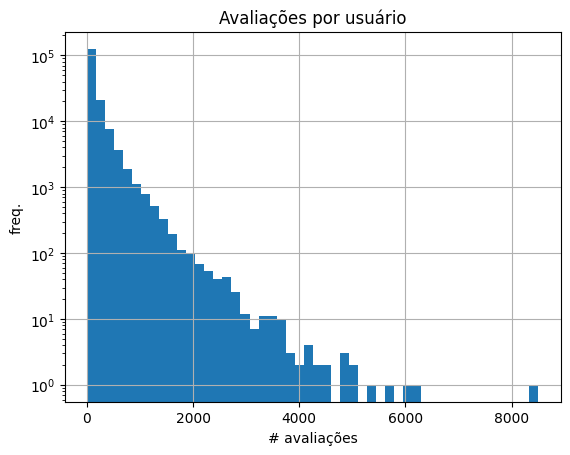

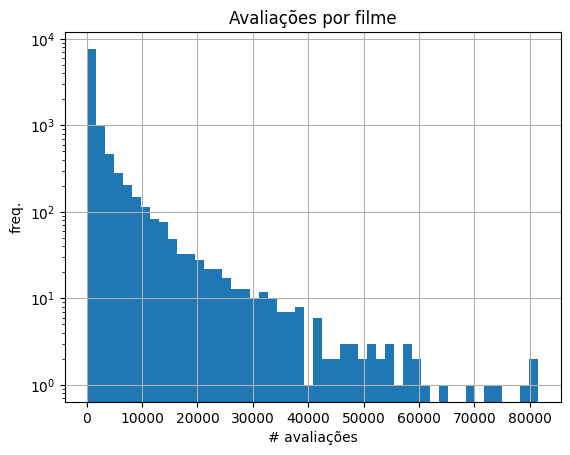

In [45]:
# avaliações por usuário
ratings_per_user = ratings.groupby("userId").size()

plt.figure()
ratings_per_user.hist(bins=50)
plt.title("Avaliações por usuário")
plt.xlabel("# avaliações")
plt.ylabel("freq.")
plt.yscale("log")              # distrib. muito longa
plt.savefig(FIGS / "ratings_per_user.png", dpi=120)

# avaliações por filme
ratings_per_movie = ratings.groupby("movieId").size()

plt.figure()
ratings_per_movie.hist(bins=50)
plt.title("Avaliações por filme")
plt.xlabel("# avaliações")
plt.ylabel("freq.")
plt.yscale("log")
plt.savefig(FIGS / "ratings_per_movie.png", dpi=120)


In [46]:
summary = pd.DataFrame({
    "Métrica": ["Usuários", "Filmes", "Avaliações", "Sparsidade (%)"],
    "Valor"  : [n_users, n_movies, len(ratings), round(sparsity*100, 2)]
})
summary


,Métrica,Valor
0,Usuários,162540.00
1,Filmes,10326.00
2,Avaliações,24443380.00
3,Sparsidade (%),98.54


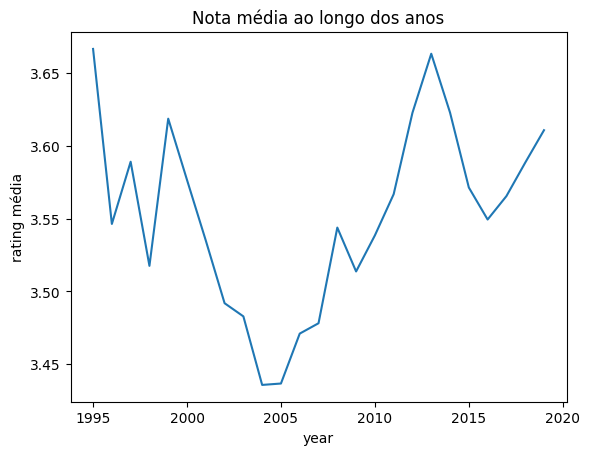

In [47]:
ratings["year"] = pd.to_datetime(ratings["timestamp"], unit="s").dt.year
avg_by_year = ratings.groupby("year")["rating"].mean()

plt.figure()
avg_by_year.plot()
plt.title("Nota média ao longo dos anos")
plt.ylabel("rating média")
plt.savefig(FIGS / "rating_by_year.png", dpi=120)


Film-Noir             3.743389
(no genres listed)    3.661827
Documentary           3.658601
War                   3.550417
Drama                 3.465981
dtype: float64


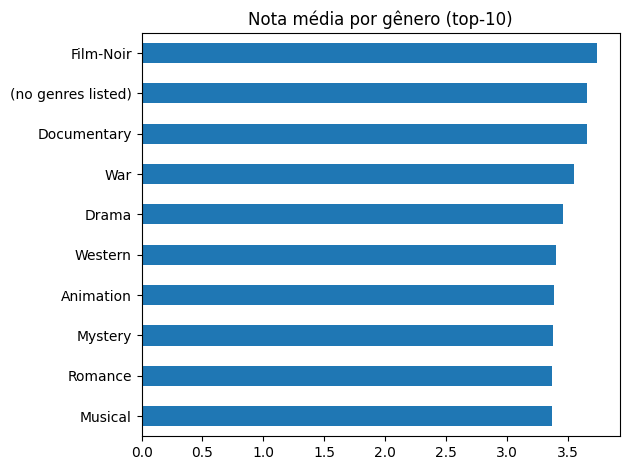

In [ ]:
# 1) média de rating por movieId  ----------------------------
avg_per_movie = (
    ratings.groupby("movieId")["rating"]
           .mean()
           .rename("avg_rating")          # vira Series com nome
)

# 2) merge no DataFrame de filmes ----------------------------
movies = movies.merge(avg_per_movie, on="movieId", how="left")

# 3) agora o cálculo por gênero ------------------------------
genre_avg = (
    movies[genre_cols].mul(movies["avg_rating"], axis=0)
                      .sum() / movies[genre_cols].sum()
).sort_values(ascending=False)

print(genre_avg.head(5))

genre_avg.head(10).plot(kind="barh")
plt.title("Nota média por gênero (top-10)")
plt.gca().invert_yaxis()
plt.tight_layout(); plt.savefig(FIGS / "avg_rating_by_genre.png", dpi=120)